In [ ]:
pip install shap tensorflow pandas numpy matplotlib seaborn scikit-learn imblearn --q

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

In [ ]:
# Loading dataset
df = pd.read_csv("creditcard.csv")

fraud_cases = df[df['Class'] == 1]
non_fraud_cases = df[df['Class'] == 0]

print(f"\nTotal fraud cases: {fraud_cases.shape[0]}")
print(f"\nTotal non-fraud cases: {non_fraud_cases.shape[0]}")
print(df.shape)
print(df.info())

# checking missing values
print("Missing Values:\n", df.isnull().sum())
print("---------------------")
# checking duplicate
print("Duplicates:", df.duplicated().sum())



Total fraud cases: 492

Total non-fraud cases: 284315
(284807, 31)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non

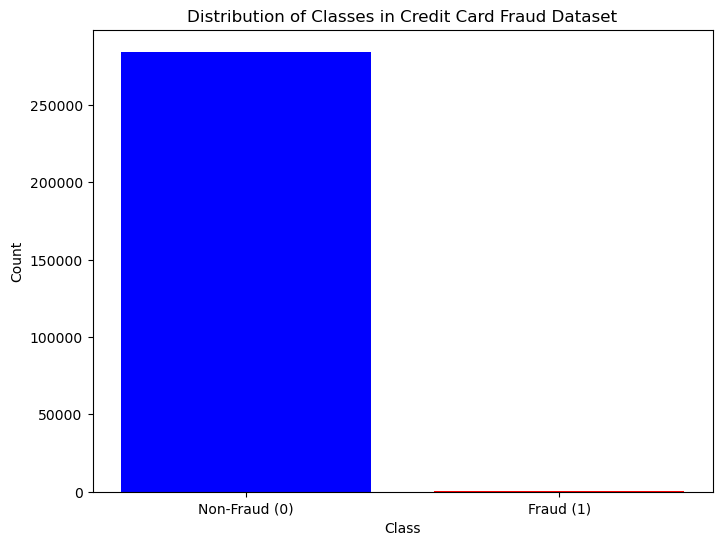

In [5]:
# graph of fraud vs non-fraud
x = df['Class'].value_counts()

plt.figure(figsize=(8, 6))
plt.bar(x.index, x.values, color=['blue', 'red'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes in Credit Card Fraud Dataset')
plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()


In [ ]:
def preprocess_and_optimize_data(file_path='creditcard.csv'):
    df = pd.read_csv(file_path)
    df = df.drop_duplicates().dropna()

    X = df.drop('Class', axis=1)
    y = df['Class']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    print("Normalization check:")
    print(f"Mean of scaled features: {np.mean(X_scaled, axis=0).mean():.4f}")
    print(f"Std of scaled features: {np.std(X_scaled, axis=0).mean():.4f}")

    smote = SMOTE(random_state=42, sampling_strategy='auto')
    X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

    print("\nClass distribution before SMOTE:")
    print(y.value_counts())
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_balanced).value_counts())

    plt.figure(figsize=(8, 6))
    plt.bar([0, 1], pd.Series(y_balanced).value_counts().values, color=['blue', 'red'])
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Distribution of Classes After SMOTE')
    plt.xticks([0, 1], ['Non-Fraud (0)', 'Fraud (1)'])
    plt.show()

    X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.3, random_state=42)

    return X_train, X_test, y_train, y_test



In [ ]:
X_train, X_test, y_train, y_test = preprocess_and_optimize_data()

In [8]:
def build_and_evaluate_model(activation_hidden, optimizer_name):
    model = Sequential([
        Dense(32, input_dim=X_train.shape[1], activation=activation_hidden),
        Dense(16, activation=activation_hidden),
        Dense(1, activation='sigmoid')
    ])

    optimizer = {
        'SGD': SGD(),
        'Adam': Adam(),
        'RMSProp': RMSprop()
    }[optimizer_name]

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    history = model.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0, validation_split=0.2)

    plt.plot(history.history['accuracy'], label='train_accuracy')
    plt.plot(history.history['val_accuracy'], label='val_accuracy')
    plt.title(f'Accuracy for {activation_hidden} with {optimizer_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(f"\nResults for Activation: {activation_hidden}, Optimizer: {optimizer_name}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {activation_hidden} + {optimizer_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    final_train_loss = history.history['loss'][-1]
    final_train_acc = history.history['accuracy'][-1]
    final_val_loss = history.history['val_loss'][-1]
    final_val_acc = history.history['val_accuracy'][-1]

    print(f"Final Training Loss: {final_train_loss:.4f}, Accuracy: {final_train_acc:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}, Accuracy: {final_val_acc:.4f}")

    return history


In [ ]:
results = {}
for activation in ['tanh', 'relu']:
    for optimizer in ['SGD', 'Adam', 'RMSProp']:
        hist = build_and_evaluate_model(activation, optimizer)
        results[f"{activation}_{optimizer}"] = hist

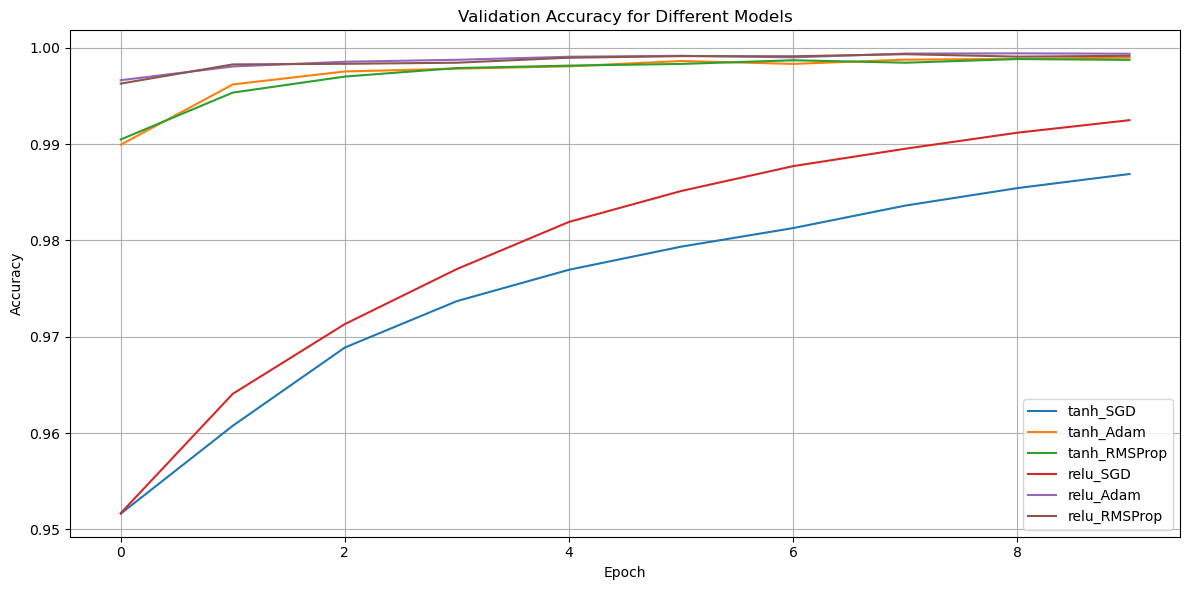

In [11]:
plt.figure(figsize=(12, 6))
for key, hist in results.items():
    plt.plot(hist.history['val_accuracy'], label=key)
plt.title("Validation Accuracy for Different Models")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

5311/5311 ━━━━━━━━━━━━━━━━━━━━ 5s 867us/step
5311/5311 ━━━━━━━━━━━━━━━━━━━━ 5s 859us/step
5311/5311 ━━━━━━━━━━━━━━━━━━━━ 4s 821us/step
5311/5311 ━━━━━━━━━━━━━━━━━━━━ 4s 840us/step
5311/5311 ━━━━━━━━━━━━━━━━━━━━ 4s 843us/step
5311/5311 ━━━━━━━━━━━━━━━━━━━━ 5s 865us/step


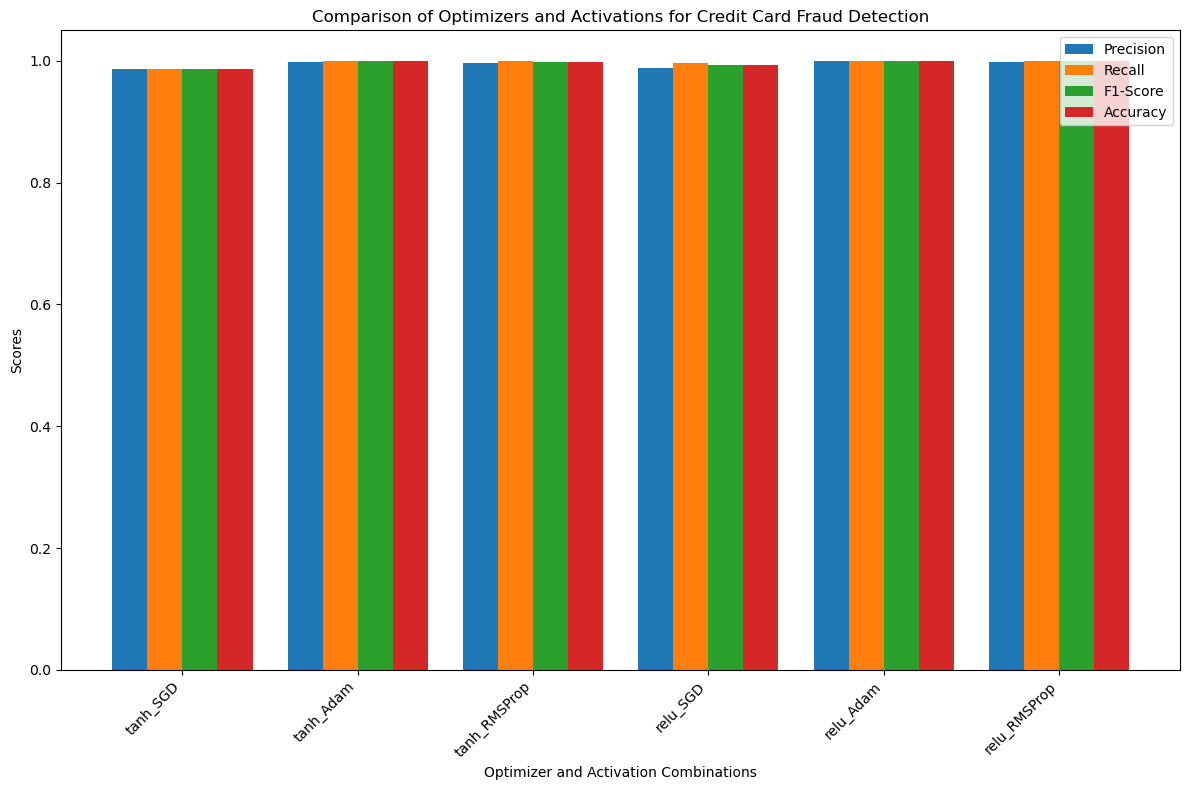


Best Combination: relu_Adam with F1-Score: 0.9993


In [12]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

metrics = {
    'Optimizer': [],
    'Precision': [],
    'Recall': [],
    'F1-Score': [],
    'Accuracy': []
}

for key, hist in results.items():
    activation, optimizer = key.split('_')
    y_pred = (hist.model.predict(X_test) > 0.5).astype("int32")
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    acc = accuracy_score(y_test, y_pred)
    metrics['Optimizer'].append(f"{activation}_{optimizer}")
    metrics['Precision'].append(precision)
    metrics['Recall'].append(recall)
    metrics['F1-Score'].append(f1)
    metrics['Accuracy'].append(acc)

metrics_df = pd.DataFrame(metrics)

plt.figure(figsize=(12, 8))
bar_width = 0.2
index = np.arange(len(metrics_df['Optimizer']))

plt.bar(index, metrics_df['Precision'], bar_width, label='Precision')
plt.bar(index + bar_width, metrics_df['Recall'], bar_width, label='Recall')
plt.bar(index + 2 * bar_width, metrics_df['F1-Score'], bar_width, label='F1-Score')
plt.bar(index + 3 * bar_width, metrics_df['Accuracy'], bar_width, label='Accuracy')

plt.xlabel('Optimizer and Activation Combinations')
plt.ylabel('Scores')
plt.title('Comparison of Optimizers and Activations for Credit Card Fraud Detection')
plt.xticks(index + 1.5 * bar_width, metrics_df['Optimizer'], rotation=45, ha='right')
plt.legend()
plt.tight_layout()

# Save and show the plot
plt.savefig('optimizer_activation_comparison.png')
plt.show()

# Find best combination based on F1-score
best_idx = np.argmax(metrics_df['F1-Score'])
best_combo = metrics_df.iloc[best_idx]
print(f"\nBest Combination: {best_combo['Optimizer']} with F1-Score: {best_combo['F1-Score']:.4f}")
